In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
file = "../code/data/as-skitter.pairs.space.csv"
df = pd.read_csv(file)

# add new columns for lastLayer w/o inter
for prefix in ['nodes','edges','dfsNodes','dfsEdges']:
    for dir in ['S','T']:
        newName = f"{prefix}InLastLayer{dir}\inter"
        lastLayer = f"{prefix}InLastLayer{dir}"
        intersection = prefix+"InInter"
        if prefix[0:3]=='dfs' and dir=='T':
            df[newName] = [0]*len(df)
        else:
            df[newName] = df[lastLayer] - df[intersection]

# add flow column
df['flow'] = df['flowBefore'].shift(-1, fill_value=0) - df['flowBefore']
df['flow'] = df['flow'].clip(lower=0)

print(f'read {file} with {len(df)} rows')

read ../code/data/as-skitter.pairs.space.csv with 9616 rows


In [3]:
colors = {
    'BeforeLastLayerS': '#56B4E9', 
    'InLastLayerS\inter': '0.75', 
    'InInter': '#D55E00', 
    'InLastLayerT\inter': '0.75', 
    'BeforeLastLayerT': '#009E73',
}
    
allEdges = [
    'edgesBeforeLastLayerS',
    'edgesInLastLayerS\inter',
    'edgesInInter',
    'edgesInLastLayerT\inter',
    'edgesBeforeLastLayerT'
]
bfsEdges = ['edgesBeforeLastLayerS', 'edgesBeforeLastLayerT']
dfsEdges = [
    'dfsEdgesBeforeLastLayerS',
    #'dfsEdgesInLastLayerS\inter',
    'dfsEdgesInInter',
    'dfsEdgesInLastLayerT\inter',
    'dfsEdgesBeforeLastLayerT'
]

dfsEdges2 = [
    'dfsEdgesBeforeLastLayerS',
    'dfsEdgesInLastLayerS\inter',
    'dfsEdgesInInter',
    'dfsEdgesInLastLayerT\inter',
    'dfsEdgesBeforeLastLayerT'
]

nameMapping = {
    'BeforeLastLayerS': 'Forward Search', 
    'InLastLayerS\inter': 'Next Forward Layer', 
    'InInter': 'Intersection', 
    'InLastLayerT\inter': 'Next Backward Layer', 
    'BeforeLastLayerT': 'Backward Seach',
}

num_pairs = len(df[df.DIRECTION=='UNI'].groupby(['S','T']))

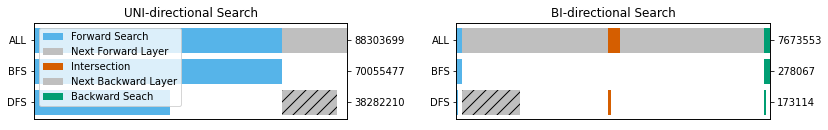

In [14]:

fig, axs = plt.subplots(1,2,figsize=(12, 2.3))

for dir, group in df.groupby('DIRECTION'):
    ax = axs[1] if dir=='BI' else axs[0]
    data= group.sum()

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, data[allEdges].sum())

    # total space
    start = {}
    offset = 0
    for cat in allEdges:
        start[cat] = offset
        ax.barh('ALL', data[cat], left=start[cat], label=nameMapping[cat[5:]], color=colors[cat[5:]])
        offset += data[cat]

    # bfs search space
    for cat in bfsEdges:
        ax.barh('BFS', data[cat], left=start[cat], color=colors[cat[5:]])

    # dfs search space
    for cat in dfsEdges:
        ax.barh('DFS', data[cat], left=start['e'+cat[4:]], color=colors[cat[8:]])
    # do dfsEdgesInLastLayerS\inter with different color and not include it in total numbers
    ax.barh('DFS', 
            data['dfsEdgesInLastLayerS\inter'], 
            left=start['edgesInLastLayerS\inter'], 
            color='0.75',
            hatch='//',
            alpha=.99) # alpha is a hack to make hatch visible in pdf
        
        
    ax2 = ax.twinx()
    ax2.set_yticks(ax.get_yticks())
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticklabels(f'{data[cats].sum()//num_pairs}' for cats in [allEdges, bfsEdges, dfsEdges])
    
    ax.set_title(f'{dir}-directional Search')

fig.tight_layout(pad=2.5)    
axs[0].legend(loc='upper left')
plt.savefig('eval_space_total.pdf', bbox_inches='tight', format='pdf')
plt.show()

number of trivial cuts (min deg = flow): 882  of 1000
boxplot and histogram of flow value by degree of smaller terminal (between 10 and 16)


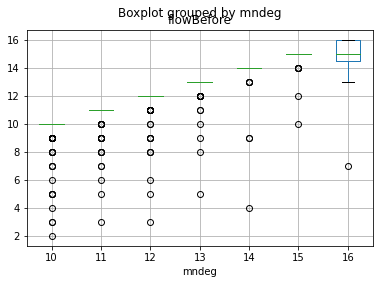

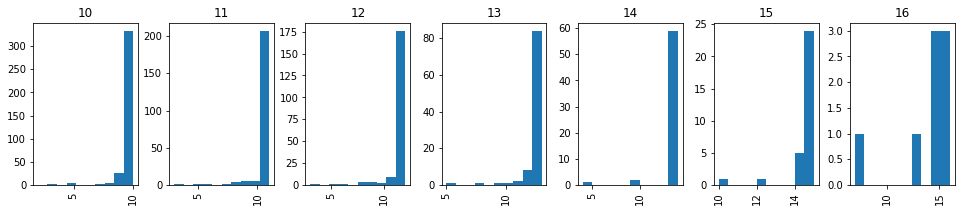

In [6]:
# how trivial are cuts
by_st = df.groupby(['S','T'])
mx = by_st.max()
mx['mndeg'] = mx[['SDEG','TDEG']].min(axis=1)

mx.boxplot('flowBefore', by='mndeg')
mx.hist('flowBefore', by='mndeg', figsize=(16,3), layout=(1,7))

print('number of trivial cuts (min deg = flow):', len(mx[mx.flowBefore==mx.mndeg]), ' of 1000')
print('boxplot and histogram of flow value by degree of smaller terminal (between 10 and 16)')

In [7]:
# aggregate totals
n = 1696415
m = 11095298

print('Stats and Search Space')
print('avg dist refers to the original graph')
print('rounds include the last round where no flow is found')
print('flow per round ignores the last round')
print('percent are relative to the full graph')
print()


for dir, dir_data in df.groupby('DIRECTION'):
    runs = dir_data.groupby(['S','T'])
    onlyLast = dir_data[dir_data.flow==0]
    butLast = dir_data[dir_data.flow !=0]
    
    print('Direction  ', dir)
    print('avg dist   ', runs['distOfSink'].first().mean())
    print('avg SDEG   ', runs.SDEG.first().mean())
    print('avg TDEG   ', runs.TDEG.first().mean())
    print('avg rounds ', runs.ROUND.max().add(1).mean())
    print('avg flow/R ', round(butLast.flow.mean(),2))

    totalBFS = dir_data[bfsEdges].sum(axis=1).mean()
    onlyBFS = onlyLast[bfsEdges].sum(axis=1).mean()
    butBFS = butLast[bfsEdges].sum(axis=1).mean()
    totalDFS = butLast[dfsEdges].sum(axis=1).mean() # there is no dfs in last
    print('Search Space')
    print('BFS')
    print('  total    ', int(totalBFS), f'({100*totalBFS/2/m:.2f}%)')
    print('  last     ', int(onlyBFS), f'({100*onlyBFS/2/m:.2f}%)')
    print('  w/o last ', int(butBFS), f'({100*butBFS/2/m:.2f}%)')
    print('DFS')
    print('  w/o last ', int(totalDFS), f'({100*totalDFS/2/m:.2f}%)')
    totalMAXFLOW = runs[bfsEdges+dfsEdges].sum().sum(axis=1)
    #totalMAXFLOW.plot.box()
    #plt.show()
    print('MAXFLOW')
    print('  total    ', int(totalMAXFLOW.mean()), f'({100*totalMAXFLOW.mean()/2/m:.2f}%)')
    print()

    


Stats and Search Space
avg dist refers to the original graph
rounds include the last round where no flow is found
flow per round ignores the last round
percent are relative to the full graph

Direction   BI
avg dist    4.199
avg SDEG    12.499
avg TDEG    12.421
avg rounds  4.808
avg flow/R  2.91
Search Space
BFS
  total     57834 (0.26%)
  last      39 (0.00%)
  w/o last  73011 (0.33%)
DFS
  w/o last  45460 (0.20%)
MAXFLOW
  total     451182 (2.03%)

Direction   UNI
avg dist    4.199
avg SDEG    12.499
avg TDEG    12.421
avg rounds  4.808
avg flow/R  2.91
Search Space
BFS
  total     14570606 (65.66%)
  last      9807296 (44.20%)
  w/o last  15821475 (71.30%)
DFS
  w/o last  10053101 (45.30%)
MAXFLOW
  total     108337687 (488.21%)

